In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossP = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    glossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    glossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, glossP, glossA, dlossA, glossQ, dlossQ

In [7]:
def model_opt(g_lossP, g_lossA, d_lossA, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_optP = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossP, var_list=g_vars)
        g_optA = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossA, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
    return g_optP, g_optA, d_optA

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_lossP, self.g_lossA, self.d_lossA, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_optP, self.g_optA, self.d_optA = model_opt(g_lossP=self.g_lossP, 
                                                          g_lossA=self.g_lossA, 
                                                          d_lossA=self.d_lossA, 
                                                          g_learning_rate=g_learning_rate, 
                                                          d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        glossP_batch, glossA_batch, dlossA_batch= [], [], []
        glossQ_batch, dlossQ_batch= [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            glossP, dlossA, glossQ, dlossQ, _, _ = sess.run([model.g_lossP, model.d_lossA, 
                                                             model.g_lossQ, model.d_lossQ,
                                                             model.g_optP, model.d_optA],
                                                            feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates})
            glossA, _ = sess.run([model.g_lossA, model.g_optA], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            glossP_batch.append(glossP)
            dlossA_batch.append(dlossA)
            glossA_batch.append(glossA)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'glossP:{:.4f}'.format(np.mean(glossP_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'glossA:{:.4f}'.format(np.mean(glossA_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 glossP:0.7839 dlossA:2.1893 glossA:1.4071 glossQ:1.0084 dlossQ:0.9783 exploreP:0.9979
Episode:1 meanR:19.5000 R:18.0000 rate:0.0360 glossP:0.7842 dlossA:2.1958 glossA:1.4086 glossQ:1.0048 dlossQ:0.9805 exploreP:0.9961
Episode:2 meanR:22.3333 R:28.0000 rate:0.0560 glossP:0.7615 dlossA:2.1749 glossA:1.4028 glossQ:1.0063 dlossQ:0.9524 exploreP:0.9934
Episode:3 meanR:20.7500 R:16.0000 rate:0.0320 glossP:0.7372 dlossA:2.1540 glossA:1.3974 glossQ:1.0060 dlossQ:0.9374 exploreP:0.9918
Episode:4 meanR:21.8000 R:26.0000 rate:0.0520 glossP:0.7280 dlossA:2.1390 glossA:1.3939 glossQ:1.0067 dlossQ:0.9216 exploreP:0.9893
Episode:5 meanR:20.8333 R:16.0000 rate:0.0320 glossP:0.7102 dlossA:2.1300 glossA:1.3912 glossQ:1.0069 dlossQ:0.9015 exploreP:0.9877
Episode:6 meanR:20.7143 R:20.0000 rate:0.0400 glossP:0.7026 dlossA:2.1202 glossA:1.3879 glossQ:1.0167 dlossQ:0.8434 exploreP:0.9857
Episode:7 meanR:19.3750 R:10.0000 rate:0.0200 glossP:0.6878 dlossA:2.1083 gl

Episode:62 meanR:23.8095 R:22.0000 rate:0.0440 glossP:0.0449 dlossA:1.5945 glossA:1.2672 glossQ:1.0716 dlossQ:0.6069 exploreP:0.8621
Episode:63 meanR:23.7656 R:21.0000 rate:0.0420 glossP:0.0826 dlossA:1.6124 glossA:1.2682 glossQ:1.0697 dlossQ:0.6093 exploreP:0.8603
Episode:64 meanR:24.1231 R:47.0000 rate:0.0940 glossP:0.0945 dlossA:1.6221 glossA:1.2744 glossQ:1.0615 dlossQ:0.6262 exploreP:0.8563
Episode:65 meanR:23.9545 R:13.0000 rate:0.0260 glossP:0.0762 dlossA:1.6090 glossA:1.2688 glossQ:1.0667 dlossQ:0.6296 exploreP:0.8552
Episode:66 meanR:24.1343 R:36.0000 rate:0.0720 glossP:0.0785 dlossA:1.6106 glossA:1.2713 glossQ:1.0705 dlossQ:0.6369 exploreP:0.8522
Episode:67 meanR:24.0882 R:21.0000 rate:0.0420 glossP:0.0255 dlossA:1.5780 glossA:1.2626 glossQ:1.0701 dlossQ:0.6349 exploreP:0.8504
Episode:68 meanR:24.2174 R:33.0000 rate:0.0660 glossP:0.0669 dlossA:1.5954 glossA:1.2613 glossQ:1.0735 dlossQ:0.6470 exploreP:0.8477
Episode:69 meanR:24.2143 R:24.0000 rate:0.0480 glossP:0.0616 dlossA:1

Episode:124 meanR:21.1900 R:12.0000 rate:0.0240 glossP:-0.2462 dlossA:1.4354 glossA:1.1927 glossQ:1.0992 dlossQ:1.2296 exploreP:0.7629
Episode:125 meanR:21.2100 R:15.0000 rate:0.0300 glossP:-0.3088 dlossA:1.4315 glossA:1.1907 glossQ:1.1249 dlossQ:1.3081 exploreP:0.7618
Episode:126 meanR:21.1900 R:14.0000 rate:0.0280 glossP:-0.4048 dlossA:1.4271 glossA:1.1897 glossQ:1.1600 dlossQ:1.4024 exploreP:0.7607
Episode:127 meanR:21.2200 R:20.0000 rate:0.0400 glossP:-0.3608 dlossA:1.3915 glossA:1.1619 glossQ:1.1221 dlossQ:1.3193 exploreP:0.7592
Episode:128 meanR:21.1800 R:10.0000 rate:0.0200 glossP:-0.4356 dlossA:1.4211 glossA:1.1797 glossQ:1.1292 dlossQ:1.4074 exploreP:0.7585
Episode:129 meanR:21.0400 R:14.0000 rate:0.0280 glossP:-0.3769 dlossA:1.4316 glossA:1.1908 glossQ:1.1141 dlossQ:1.3136 exploreP:0.7574
Episode:130 meanR:21.1400 R:21.0000 rate:0.0420 glossP:-0.4961 dlossA:1.3984 glossA:1.1733 glossQ:1.1328 dlossQ:1.3813 exploreP:0.7558
Episode:131 meanR:21.0700 R:14.0000 rate:0.0280 glossP:

Episode:185 meanR:16.1800 R:11.0000 rate:0.0220 glossP:-2.0253 dlossA:1.1460 glossA:1.0525 glossQ:1.3293 dlossQ:0.8496 exploreP:0.6973
Episode:186 meanR:16.1000 R:17.0000 rate:0.0340 glossP:-2.4005 dlossA:1.1042 glossA:1.0301 glossQ:1.3690 dlossQ:0.8648 exploreP:0.6961
Episode:187 meanR:16.0700 R:10.0000 rate:0.0200 glossP:-1.9039 dlossA:1.1626 glossA:1.0707 glossQ:1.3348 dlossQ:0.8388 exploreP:0.6954
Episode:188 meanR:16.1300 R:25.0000 rate:0.0500 glossP:-1.9309 dlossA:1.1464 glossA:1.0438 glossQ:1.3349 dlossQ:0.9201 exploreP:0.6937
Episode:189 meanR:16.0900 R:16.0000 rate:0.0320 glossP:-2.0373 dlossA:1.1226 glossA:1.0307 glossQ:1.3589 dlossQ:0.8598 exploreP:0.6926
Episode:190 meanR:16.0800 R:15.0000 rate:0.0300 glossP:-1.8811 dlossA:1.1622 glossA:1.0598 glossQ:1.2720 dlossQ:0.8804 exploreP:0.6916
Episode:191 meanR:16.1300 R:23.0000 rate:0.0460 glossP:-2.0329 dlossA:1.1417 glossA:1.0486 glossQ:1.3527 dlossQ:0.9092 exploreP:0.6900
Episode:192 meanR:16.0100 R:10.0000 rate:0.0200 glossP:

Episode:246 meanR:14.5400 R:11.0000 rate:0.0220 glossP:-2.7931 dlossA:1.0373 glossA:1.0034 glossQ:1.4071 dlossQ:0.5960 exploreP:0.6382
Episode:247 meanR:14.4500 R:12.0000 rate:0.0240 glossP:-3.0061 dlossA:1.0196 glossA:0.9957 glossQ:1.4196 dlossQ:0.5822 exploreP:0.6374
Episode:248 meanR:14.3700 R:15.0000 rate:0.0300 glossP:-2.8347 dlossA:1.0241 glossA:0.9888 glossQ:1.4129 dlossQ:0.6126 exploreP:0.6365
Episode:249 meanR:14.4400 R:17.0000 rate:0.0340 glossP:-2.7915 dlossA:1.0282 glossA:1.0035 glossQ:1.4882 dlossQ:0.6544 exploreP:0.6354
Episode:250 meanR:14.4200 R:9.0000 rate:0.0180 glossP:-2.9354 dlossA:1.0335 glossA:1.0170 glossQ:1.6407 dlossQ:0.8117 exploreP:0.6348
Episode:251 meanR:14.4000 R:10.0000 rate:0.0200 glossP:-3.0501 dlossA:0.9997 glossA:0.9813 glossQ:1.4990 dlossQ:0.6076 exploreP:0.6342
Episode:252 meanR:14.3100 R:15.0000 rate:0.0300 glossP:-2.5618 dlossA:1.0771 glossA:1.0843 glossQ:2.4231 dlossQ:1.2748 exploreP:0.6333
Episode:253 meanR:14.2800 R:9.0000 rate:0.0180 glossP:-3

Episode:307 meanR:14.5100 R:19.0000 rate:0.0380 glossP:-4.1193 dlossA:0.8737 glossA:0.9081 glossQ:1.7489 dlossQ:0.7406 exploreP:0.5853
Episode:308 meanR:14.5700 R:18.0000 rate:0.0360 glossP:-4.2039 dlossA:0.8913 glossA:0.9321 glossQ:1.7297 dlossQ:0.6959 exploreP:0.5842
Episode:309 meanR:14.6300 R:20.0000 rate:0.0400 glossP:-4.3251 dlossA:0.8646 glossA:0.9105 glossQ:1.7943 dlossQ:0.7789 exploreP:0.5831
Episode:310 meanR:14.6200 R:11.0000 rate:0.0220 glossP:-4.1619 dlossA:0.8986 glossA:0.9381 glossQ:1.7995 dlossQ:0.9307 exploreP:0.5824
Episode:311 meanR:14.6400 R:12.0000 rate:0.0240 glossP:-4.3427 dlossA:0.8970 glossA:0.9349 glossQ:1.7245 dlossQ:0.9204 exploreP:0.5818
Episode:312 meanR:14.6200 R:10.0000 rate:0.0200 glossP:-4.4978 dlossA:0.8648 glossA:0.9092 glossQ:1.7715 dlossQ:0.7498 exploreP:0.5812
Episode:313 meanR:14.6400 R:13.0000 rate:0.0260 glossP:-4.2987 dlossA:0.9065 glossA:0.9657 glossQ:1.8118 dlossQ:0.8697 exploreP:0.5804
Episode:314 meanR:14.6500 R:11.0000 rate:0.0220 glossP:

Episode:368 meanR:13.7400 R:13.0000 rate:0.0260 glossP:-5.3508 dlossA:0.7990 glossA:0.8967 glossQ:2.2535 dlossQ:1.2559 exploreP:0.5402
Episode:369 meanR:13.7400 R:10.0000 rate:0.0200 glossP:-5.9774 dlossA:0.7678 glossA:0.8675 glossQ:2.1927 dlossQ:1.3029 exploreP:0.5397
Episode:370 meanR:13.7800 R:14.0000 rate:0.0280 glossP:-6.1814 dlossA:0.7921 glossA:0.9069 glossQ:2.2125 dlossQ:1.4144 exploreP:0.5390
Episode:371 meanR:13.7800 R:11.0000 rate:0.0220 glossP:-6.2798 dlossA:0.7653 glossA:0.8725 glossQ:2.2213 dlossQ:1.4284 exploreP:0.5384
Episode:372 meanR:13.7600 R:11.0000 rate:0.0220 glossP:-6.2055 dlossA:0.7574 glossA:0.8836 glossQ:2.4521 dlossQ:1.9530 exploreP:0.5378
Episode:373 meanR:13.7200 R:12.0000 rate:0.0240 glossP:-5.4660 dlossA:0.8002 glossA:0.8916 glossQ:2.1806 dlossQ:1.0736 exploreP:0.5372
Episode:374 meanR:13.7100 R:12.0000 rate:0.0240 glossP:-6.8380 dlossA:0.7722 glossA:0.9052 glossQ:2.3199 dlossQ:1.3826 exploreP:0.5365
Episode:375 meanR:13.7000 R:9.0000 rate:0.0180 glossP:-

Episode:429 meanR:12.6100 R:9.0000 rate:0.0180 glossP:-7.5603 dlossA:0.7546 glossA:0.9155 glossQ:2.6635 dlossQ:1.7476 exploreP:0.5019
Episode:430 meanR:12.5900 R:12.0000 rate:0.0240 glossP:-9.3208 dlossA:0.7335 glossA:1.0207 glossQ:4.0270 dlossQ:4.2383 exploreP:0.5013
Episode:431 meanR:12.5900 R:9.0000 rate:0.0180 glossP:-6.8475 dlossA:0.7589 glossA:0.9128 glossQ:2.7175 dlossQ:1.6718 exploreP:0.5008
Episode:432 meanR:12.5900 R:13.0000 rate:0.0260 glossP:-11.2796 dlossA:0.6996 glossA:1.0779 glossQ:5.5722 dlossQ:6.2065 exploreP:0.5002
Episode:433 meanR:12.5500 R:9.0000 rate:0.0180 glossP:-8.2530 dlossA:0.6897 glossA:0.8678 glossQ:2.9818 dlossQ:2.8377 exploreP:0.4998
Episode:434 meanR:12.5900 R:18.0000 rate:0.0360 glossP:-9.8503 dlossA:0.7342 glossA:0.9888 glossQ:3.6423 dlossQ:3.5941 exploreP:0.4989
Episode:435 meanR:12.6100 R:16.0000 rate:0.0320 glossP:-8.2162 dlossA:0.7115 glossA:0.8971 glossQ:2.9056 dlossQ:2.3493 exploreP:0.4981
Episode:436 meanR:12.6300 R:12.0000 rate:0.0240 glossP:-8

Episode:490 meanR:12.9200 R:9.0000 rate:0.0180 glossP:-13.6090 dlossA:0.6206 glossA:0.9153 glossQ:4.0302 dlossQ:5.8856 exploreP:0.4648
Episode:491 meanR:12.9300 R:9.0000 rate:0.0180 glossP:-12.2766 dlossA:0.6770 glossA:0.9956 glossQ:4.6860 dlossQ:5.4608 exploreP:0.4644
Episode:492 meanR:12.7800 R:11.0000 rate:0.0220 glossP:-12.5885 dlossA:0.6734 glossA:0.9712 glossQ:4.0302 dlossQ:4.6438 exploreP:0.4639
Episode:493 meanR:12.7900 R:11.0000 rate:0.0220 glossP:-13.9800 dlossA:0.6564 glossA:0.9916 glossQ:4.4715 dlossQ:7.1890 exploreP:0.4634
Episode:494 meanR:12.7600 R:11.0000 rate:0.0220 glossP:-12.4446 dlossA:0.6124 glossA:0.8733 glossQ:4.5104 dlossQ:4.9180 exploreP:0.4629
Episode:495 meanR:12.7700 R:10.0000 rate:0.0200 glossP:-13.6544 dlossA:0.6330 glossA:0.9431 glossQ:4.4834 dlossQ:5.8191 exploreP:0.4624
Episode:496 meanR:12.6300 R:10.0000 rate:0.0200 glossP:-15.3890 dlossA:0.5961 glossA:0.9196 glossQ:4.5111 dlossQ:7.4110 exploreP:0.4620
Episode:497 meanR:12.5900 R:10.0000 rate:0.0200 gl

Episode:551 meanR:12.2100 R:14.0000 rate:0.0280 glossP:-22.1107 dlossA:0.5869 glossA:1.0396 glossQ:6.9949 dlossQ:10.6124 exploreP:0.4328
Episode:552 meanR:12.2100 R:10.0000 rate:0.0200 glossP:-23.3958 dlossA:0.5574 glossA:1.0185 glossQ:6.7740 dlossQ:13.6612 exploreP:0.4323
Episode:553 meanR:12.1900 R:10.0000 rate:0.0200 glossP:-23.3060 dlossA:0.6055 glossA:1.0974 glossQ:6.8050 dlossQ:13.1113 exploreP:0.4319
Episode:554 meanR:12.0900 R:11.0000 rate:0.0220 glossP:-22.1289 dlossA:0.5861 glossA:1.0556 glossQ:6.9110 dlossQ:12.0221 exploreP:0.4315
Episode:555 meanR:12.0800 R:10.0000 rate:0.0200 glossP:-23.3049 dlossA:0.5991 glossA:1.0820 glossQ:6.5874 dlossQ:12.6994 exploreP:0.4310
Episode:556 meanR:12.0500 R:9.0000 rate:0.0180 glossP:-25.3879 dlossA:0.5712 glossA:1.0338 glossQ:6.6915 dlossQ:16.1744 exploreP:0.4307
Episode:557 meanR:12.0100 R:9.0000 rate:0.0180 glossP:-23.1981 dlossA:0.5401 glossA:1.0041 glossQ:8.3129 dlossQ:16.3466 exploreP:0.4303
Episode:558 meanR:11.9900 R:10.0000 rate:0.

Episode:611 meanR:11.7800 R:10.0000 rate:0.0200 glossP:-37.9123 dlossA:0.4949 glossA:1.1615 glossQ:14.1536 dlossQ:37.6845 exploreP:0.4044
Episode:612 meanR:11.8000 R:15.0000 rate:0.0300 glossP:-42.3105 dlossA:0.4969 glossA:1.2384 glossQ:13.5677 dlossQ:39.9662 exploreP:0.4038
Episode:613 meanR:11.7800 R:10.0000 rate:0.0200 glossP:-36.2387 dlossA:0.5520 glossA:1.2555 glossQ:11.3138 dlossQ:26.8888 exploreP:0.4034
Episode:614 meanR:11.8000 R:12.0000 rate:0.0240 glossP:-42.5868 dlossA:0.5607 glossA:1.3119 glossQ:9.6315 dlossQ:31.9290 exploreP:0.4030
Episode:615 meanR:11.7900 R:9.0000 rate:0.0180 glossP:-40.0244 dlossA:0.4754 glossA:1.1326 glossQ:13.3192 dlossQ:36.2048 exploreP:0.4026
Episode:616 meanR:11.8500 R:21.0000 rate:0.0420 glossP:-37.9721 dlossA:0.5519 glossA:1.2742 glossQ:11.1475 dlossQ:29.0105 exploreP:0.4018
Episode:617 meanR:11.8300 R:9.0000 rate:0.0180 glossP:-40.4776 dlossA:0.5459 glossA:1.3768 glossQ:14.0140 dlossQ:38.2126 exploreP:0.4014
Episode:618 meanR:11.8200 R:10.0000 r

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

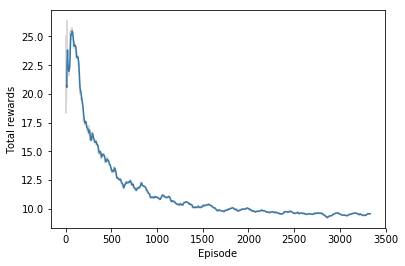

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

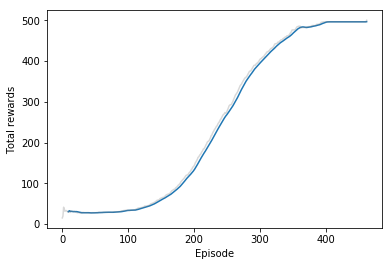

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

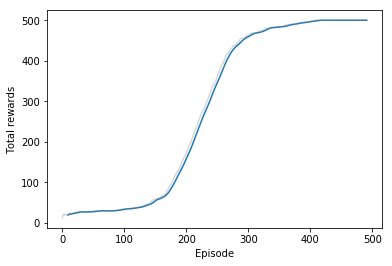

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

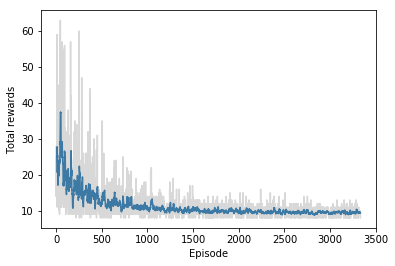

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

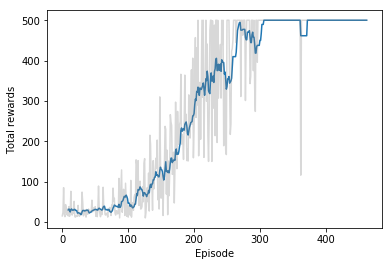

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

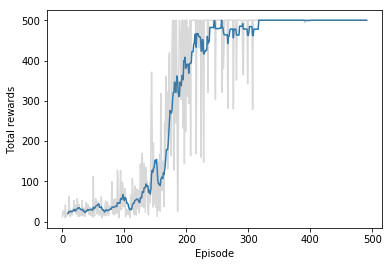

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.